# d7046e ANN course project , Group 6

The project goal is to implement a classifier for clear/cloudy sky based satellite image data. 

**Download and some checks**

In [ ]:
# downloads and extract the data from, https://drive.google.com/drive/folders/1lRCIcQo9CqFRDhUd3aZRAA46k8nLL49J

import gdown
import zipfile
import os

CLOUD_FILE_ID = "19MBh9JIJTxYIPAeO7G5RML5_ddjJ1Cpa"
CLOUD_DOWN_ENDPOINT = "https://drive.google.com/uc?id="

base_dir = os.path.abspath("../data/")  
zip_path = os.path.join(base_dir, "data.zip")  
extract_path = os.path.join(base_dir) # set to same not to create to many sub folders 

os.makedirs(extract_path, exist_ok=True)

print(f"downloading dataset to: {zip_path}")
gdown.download(f"{CLOUD_DOWN_ENDPOINT}{CLOUD_FILE_ID}", zip_path, quiet=False)

print(f"extracting to: {extract_path}")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.remove(zip_path)
print(f"deleted zip file: {zip_path}")

print("download and extraction completed.")
print(f"extracted files in: {extract_path}")
print(f"extracted content: {os.listdir(extract_path)}")


<small>Trying to figure out how the data is structured.</small>

In [ ]:
import numpy as np
import os


# length of gts files, trying to find out what to use and make sure where tha labels are.
train_gts = np.load(os.path.join(base_dir, "skogsstyrelsen-data/skogs_gts_train.npy"))
train_names = np.load(os.path.join(base_dir, "skogsstyrelsen-data/skogs_names_train.npy"))
print(f"length of train_gts:{len(train_gts)} , length of train_names:{len(train_names)}")

val_gts = np.load("../data/skogsstyrelsen-data/skogs_gts_val.npy")
val_names = np.load("../data/skogsstyrelsen-data/skogs_names_val.npy")
print(f"length of train_gts:{len(val_gts)} , length of train_names:{len(val_names)}")


<small>Sample one of the objects in the .nc files</small>

In [ ]:
import xarray as xar
import numpy as np

ds = xar.open_dataset("../data/skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria/skgs_0b5101fb-44c7-ed11-9174-005056a6f472.nc")

print(ds)

check_bands = False

if check_bands:
    if 'scl' in ds:
        scl_value = ds['scl'].values.squeeze() 
        print("\n   **Scene Classification Layer (scl):**")
        print(scl_value)

    # updated to a better check 
    for band_name, band_data in ds.data_vars.items():
        values = band_data.values.squeeze()

        print(f"\n **Band: {band_name}**")
        print(f"   - Shape: {values.shape}")
        print(f"   - Dtype: {values.dtype}")
        print(f"   - Min: {np.min(values):.4f}, Max: {np.max(values):.4f}, Mean: {np.mean(values):.4f}")
        print("    - Array values:")
        print(values)
else:
    print("set check_bands to True to print the bands")


**Setup Cells**

In [38]:
import os
import torch
import xarray as xar
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

DATA_PATH = "../data/skogsstyrelsen-data/"
BEST_MODEL_BASE_PATH = "stored/"

BANDS = ['b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b8a', 'b09', 'b11', 'b12']
IMAGE_SIZE = 20 # im unsure about this one, bands have shape (21, 20) ... idk if we are missing something with SIZE 20 ... 
EPOCHS = 50
BATCH_SIZE = 32
LR = 1e-3


if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
    print(
        "Cuda does not seem to be available in your environment, try installing a torch package compiled with cuda enabled if u have cuda installed in ur os.\n"
        "Uninstall torch, torchaudio, torchvision, and then run: torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121\n"
    )
    
print(f"Running with: DEVICE = {DEVICE}")

Running with: DEVICE = cuda


<small>Utils functions to load the data from skogs</small>

In [39]:

def get_skogs_paths(split_suffix: str):
    """ Returns concatenated paths depending on what split that is needed. """
    names_path = os.path.join(DATA_PATH, f"skogs_names_{split_suffix}.npy")
    labels_path = os.path.join(os.path.join(DATA_PATH, f"skogs_gts_{split_suffix}.npy"))
    return names_path, labels_path

def load_skogs_data(split_suffix: str):
    """Loads a dataset split into numpy arrays for images and binary labels."""
    names_path, labels_path = get_skogs_paths(split_suffix)
    names = np.load(names_path, allow_pickle=True)                       # list of paths to nc files
    labels = np.load(labels_path, allow_pickle=True).astype(np.float32)  # binary values from the gts files

    x_list = []
    y_list = []

    for name, label in zip(names, labels):  
        nc_file = os.path.join(DATA_PATH, "2A-netcdfs-cropped-from-nuria", os.path.basename(name))
        nc_file = os.path.normpath(nc_file)  # normalize path for different OS

        if os.path.exists(nc_file):
            with xar.open_dataset(nc_file, engine="netcdf4") as ds:
                band_arrays = [(ds[band].values.squeeze() - 1000) / 10000 for band in BANDS]

            
            band_arrays_fixed = [
                torch.tensor(band[:IMAGE_SIZE, :IMAGE_SIZE], dtype=torch.float32) 
                if band.shape[0] >= IMAGE_SIZE and band.shape[1] >= IMAGE_SIZE
                else torch.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=torch.float32)  
                for band in band_arrays
            ]

            x = torch.stack(band_arrays_fixed)  
        
        else:
            print(f"File not found: {nc_file}")
            x = torch.zeros((len(BANDS), IMAGE_SIZE, IMAGE_SIZE), dtype=torch.float32) 

        x_list.append(x)  
        y_list.append(torch.tensor(label, dtype=torch.float32))  

    return torch.stack(x_list), torch.tensor(y_list) 

class SkogsBinaryDataset(Dataset):
    """ PyTorch dataset for the stacked band arrays (X) and binary label (y). """
    def __init__(self, x_data, y_data):
        self.x_data: torch.Tensor = x_data # tensor for the image
        self.y_data: torch.Tensor = y_data # label for the image

    def __len__(self):
        return len(self.x_data)


    def __getitem__(self, idx):
        x = self.x_data[idx].clone().detach()
        y = self.y_data[idx].clone().detach()
        return x, y


<small>Set up data loaders, this cell is just a dev test to see that the data extraction is working</small>

In [40]:
def check_batch_shapes(ds: DataLoader):
    for x_batch, y_batch in ds:
        print(f"x_batch shape: {x_batch.shape}") # (batch_size, channels, height, width)
        print(f"y_batch shape: {y_batch.shape}") # (batch_size) , same amount of labels as input images

# change to True check batch dims
check_batch = False
if check_batch: 
    x_train, y_train = load_skogs_data("train")
    x_val, y_val = load_skogs_data("val")
    x_test, y_test = load_skogs_data("test")

    train_ds = SkogsBinaryDataset(x_train, y_train)
    val_ds = SkogsBinaryDataset(x_val, y_val)
    test_ds = SkogsBinaryDataset(x_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) 
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    print("train_split :")
    check_batch_shapes(train_loader)
    print("val_split :")
    check_batch_shapes(val_loader)
    print("test_split :")
    check_batch_shapes(test_loader)   
else:
    print("change bool to check batch dims")


change bool to check batch dims


**Model architecture 1**

In [41]:
class BinCloudCnn(nn.Module):
    def __init__(self, hidden_activation=F.relu, output_activation=torch.sigmoid, stride=2):  # the standard values for the activations are set as a dev reference, call with different values and eval
        """ call the class with different   """
        super(BinCloudCnn, self).__init__()

        self.activation_fn = hidden_activation
        self.output_activation = output_activation

        self.conv1 = nn.Conv2d(in_channels=12, out_channels=32, kernel_size=3, padding=1)  # (32, 20, 20)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # (64, 10, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=stride)

        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 1)  # fully con output layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation_fn(x)  
        x = self.pool(x)
        #print("after conv1 + pool:", x.shape) # debug print

        x = self.conv2(x)
        x = self.activation_fn(x)  
        x = self.pool(x)
        #print("after conv2 + pool:", x.shape) # debug print

        x = x.view(x.size(0), -1)
        #print("after flattening:", x.shape) # debug print

        # maybe add dropouts here
        x = self.fc1(x)
        x = self.activation_fn(x)  
        x = self.fc2(x)
        x = self.output_activation(x) 
        x = x.squeeze(1)

        return x

**Training, Validation and Testing functions**

<small>Training and validation with utils, training wraps the validation in this implementation.</small>

In [42]:
import time
import torch.optim.optimizer

def validate(
    model: BinCloudCnn,
    val_loader: DataLoader,
    loss_criterion: torch.nn.Module,  # any loss criterion from torch.nn
    device: str = DEVICE
):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad(): 
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_criterion(outputs, targets.float())
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct / total * 100

    return avg_val_loss, accuracy


def train(
        model: BinCloudCnn,
        train_loader: DataLoader,
        val_loader: DataLoader,
        loss_criterion: torch.nn.Module,    # any loss criterion from torch.nn
        optimizer: torch.optim.Optimizer,   # any optimizer from torch.optim
        epochs: int = EPOCHS,
        patience: int = 20,
        device: str = DEVICE,
        best_model_path: str = "best_model.pth",     
    ):
    
    best_model_path = f"{BEST_MODEL_BASE_PATH}{best_model_path}"
    start_time = time.time()

    model.to(device)
    print(f"model loaded to device: {device}\n")

    best_val_loss = float("inf")
    best_model_state = None
    patience_count = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    stopped_early = False

    # epoch loop, wraps the validation function
    for epoch in range(epochs):
        loss: torch.Tensor = 0 # just declare type for ide support
        total_correct = 0
        total_samples = 0
        total_train_loss = 0

        model.train()
        for batch in train_loader:
            image: torch.Tensor
            labels: torch.Tensor
            image, labels = batch  # the tuple returned from SkogsBinaryDataset
            image = image.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # gradient reset
            outputs = model(image)
            #outputs = outputs.squeeze(1)

            loss = loss_criterion(outputs, labels.float()) 
            loss.backward()
            optimizer.step() # update w

            total_train_loss +=  loss.item()

            # convert output to binary 
            predictions = (outputs >= 0.5).float()
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        epoch_train_accuracy = total_correct / total_samples * 100

        train_losses.append(avg_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # the validation call, sets the mode and stuff
        epoch_val_loss, epoch_val_accuracy = validate(model, val_loader, loss_criterion, device)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        # epoch report
        print(f"Epoch {epoch+1}/{epochs} | TrainLoss = {avg_train_loss:.4f}, TrainAccuracy = {epoch_train_accuracy:.2f}% | ValLoss = {epoch_val_loss:.4f} , ValAccuracy = {epoch_val_accuracy:.2f}%")

        # save the best model for the run
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
            patience_count = 0 # reset patience!!!
        else:
            patience_count += 1
    
        if patience_count >= patience:
            print(f"--- early stopping triggered at epoch {epoch + 1}, best ValLoss = {best_val_loss:.4f} ---")
            stopped_early = True
            print_run_time(start_time, True)
            torch.save(best_model_state, best_model_path)
            print(f"\nsaved best model to path: {best_model_path}")
            break

    if not stopped_early:
        print_run_time(start_time, False)
        torch.save(best_model_state, best_model_path)
        print(f"\nsaved best model to path: {best_model_path}")

    return model, train_losses, val_losses
        
def print_run_time(start_time, is_early):
    end_time = time.time()
    train_val_time = end_time - start_time 
    if is_early:
        print(f"\ntraining + validation early stop time = {train_val_time:.2f} s")
        return 
    print(f"\ntraining + validation no early stopping time = {train_val_time:.2f} s") 



<small>The testing function and util loader.</small>

In [43]:
def load_trained_model(model_name = "best_model.pth"):
    """ returns a trained model based on input name """
    model_path = f"{BEST_MODEL_BASE_PATH}{model_name}"
    model = BinCloudCnn()
    model.load_state_dict(torch.load(model_path))
    return model

def test(
    model: BinCloudCnn,
    criterion: torch.nn.Module,
    test_loader: DataLoader,
    device: str = DEVICE,
):
    model.to(device)
    model.eval()

    test_loss = 0
    correct = 0
    tries = 0

    preds_list = [] 
    labels_list = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            test_loss += loss.item()
            predicted = (outputs >= 0.5).long()
            correct += (predicted == y.long()).sum().item()
            tries += y.size(0)

            preds_list.append(predicted.cpu())
            labels_list.append(y.cpu())

        test_loss /= len(test_loader)
        test_accuracy = correct / tries * 100

        preds = torch.cat(preds_list, dim=0)
        labels = torch.cat(labels_list, dim=0)

        print(f"\nTest Loss: {test_loss:.4f} , Test Accuracy: {test_accuracy:.2f}%\n")
        return test_loss, test_accuracy, preds, labels

<small>visualization util</small>

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


def plot_loss_curve(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8,6))
    plt.plot(epochs, train_losses, "r", label="training Loss")
    plt.plot(epochs, val_losses, "b", label="validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (NLL)")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

def plot_confusion_matrix(preds, labels, class_names=["Clear", "Cloudy"]):
    cm = confusion_matrix(labels.numpy(), preds.numpy())
    print("\nClassification Report:")
    print(classification_report(labels.numpy(), preds.numpy(), target_names=class_names, digits=4))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

**Evaluate Architecture1**

<small>Training</small>

model loaded to device: cuda

Epoch 1/100 | TrainLoss = 0.6621, TrainAccuracy = 67.31% | ValLoss = 0.5987 , ValAccuracy = 72.22%
Epoch 2/100 | TrainLoss = 0.5328, TrainAccuracy = 75.77% | ValLoss = 0.5593 , ValAccuracy = 72.22%
Epoch 3/100 | TrainLoss = 0.4224, TrainAccuracy = 78.85% | ValLoss = 0.5251 , ValAccuracy = 80.56%
Epoch 4/100 | TrainLoss = 0.4484, TrainAccuracy = 81.54% | ValLoss = 0.5564 , ValAccuracy = 77.78%
Epoch 5/100 | TrainLoss = 0.4294, TrainAccuracy = 81.54% | ValLoss = 0.5041 , ValAccuracy = 77.78%
Epoch 6/100 | TrainLoss = 0.4294, TrainAccuracy = 80.00% | ValLoss = 0.4645 , ValAccuracy = 81.94%
Epoch 7/100 | TrainLoss = 0.4094, TrainAccuracy = 81.54% | ValLoss = 0.4676 , ValAccuracy = 83.33%
Epoch 8/100 | TrainLoss = 0.3572, TrainAccuracy = 83.46% | ValLoss = 0.4919 , ValAccuracy = 77.78%
Epoch 9/100 | TrainLoss = 0.3762, TrainAccuracy = 84.23% | ValLoss = 0.5348 , ValAccuracy = 76.39%
Epoch 10/100 | TrainLoss = 0.3111, TrainAccuracy = 84.62% | ValLoss = 0.5040 , 

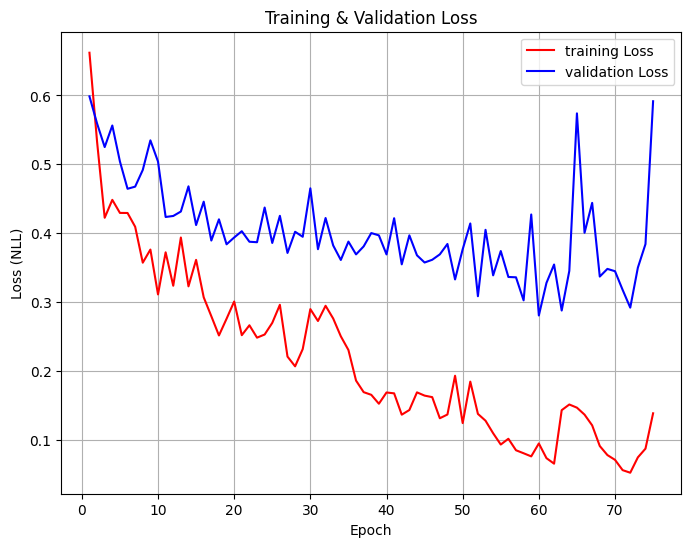

In [45]:
# setup the data loaders for training
x_train, y_train = load_skogs_data("train")
x_val, y_val = load_skogs_data("val")
x_test, y_test = load_skogs_data("test")

train_ds = SkogsBinaryDataset(x_train, y_train)
val_ds = SkogsBinaryDataset(x_val, y_val)
test_ds = SkogsBinaryDataset(x_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) 
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# set optimizer and loss criterion
model_1 = BinCloudCnn().to(DEVICE)
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=LR)
loss_criterion_1 = torch.nn.BCELoss()   # seems good, https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
best_model_1_path = "best_model_1.pth"

# training call
model_1, train_losses, val_losses = train(
    model = model_1,
    train_loader = train_loader,
    val_loader = val_loader,
    optimizer = optimizer_1,
    epochs = 100,
    patience = 15,
    loss_criterion = loss_criterion_1,
    best_model_path = best_model_1_path
)

plot_loss_curve(train_losses, val_losses)

<small>Call testing</small>

C:\Users\moell\AppData\Local\Temp\ipykernel_17680\1077782812.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.4711 , Test Accuracy: 83.00%


Classification Report:
              precision    recall  f1-score   support

       Clear     0.9825    0.7778    0.8682        72
      Cloudy     0.6279    0.9643    0.7606        28

    accuracy                         0.8300       100
   macro avg     0.8052    0.8710    0.8144       100
weighted avg     0.8832    0.8300    0.8381       100



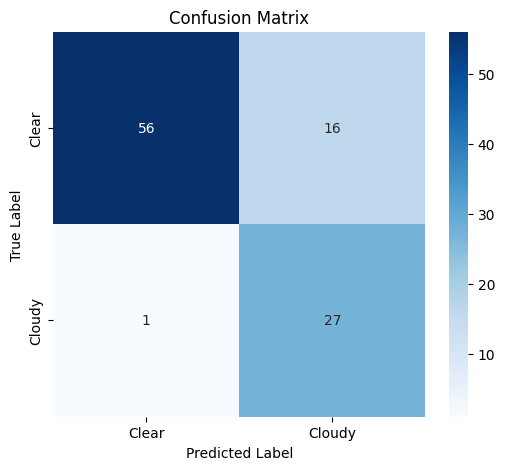

In [46]:
loaded_model_1 = load_trained_model(best_model_1_path)

test_loss, test_accuracy, preds, labels = test(
    model = loaded_model_1,
    criterion = loss_criterion_1,
    test_loader = test_loader,
    device = DEVICE,
)

plot_confusion_matrix(preds, labels)

**Architecture1 X Augmented Data**

In [47]:
# maybe Rezhuq or Vinay can contribute ? 